In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
data = pd.read_csv("day.csv")

data = data[['yr', 'season','mnth','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed','cnt']]

X = data.drop(columns=['cnt'])
y = data['cnt']

categorical_cols = ['season','mnth','weekday','weathersit']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
numeric_cols = ['temp','yr','atemp','hum','windspeed','holiday','workingday']
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])


X = np.asarray(X_encoded, dtype=np.float64)
y = np.asarray(y, dtype=np.float64).reshape(-1, 1)

Fold 1: R²=0.885, RMSE=679.08, MAE=484.25
Fold 2: R²=0.881, RMSE=658.62, MAE=490.18
Fold 3: R²=0.863, RMSE=721.13, MAE=502.33
Fold 4: R²=0.839, RMSE=709.89, MAE=516.24
Fold 5: R²=0.905, RMSE=612.56, MAE=476.60

=== Average Model Performance Across 5 Folds ===
Average R²   : 0.874 ± 0.022
Average RMSE : 676.26 ± 38.79
Average MAE  : 493.92 ± 13.98


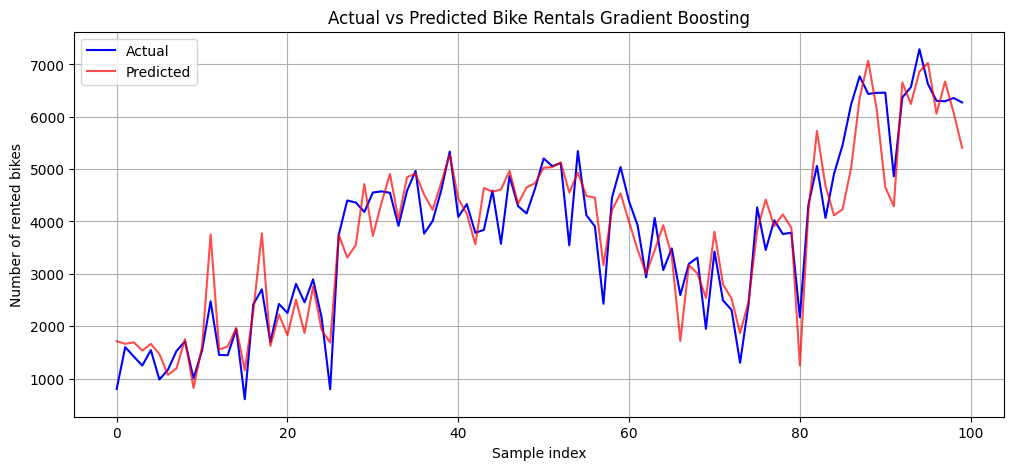

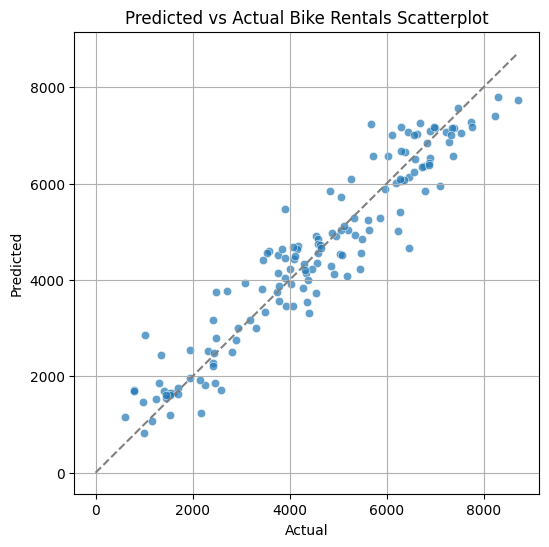

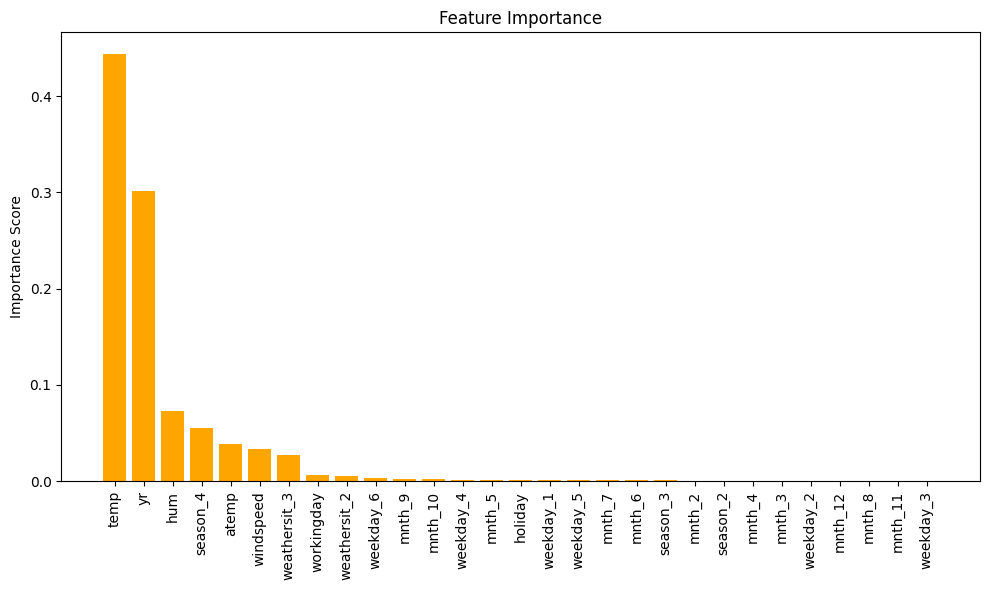

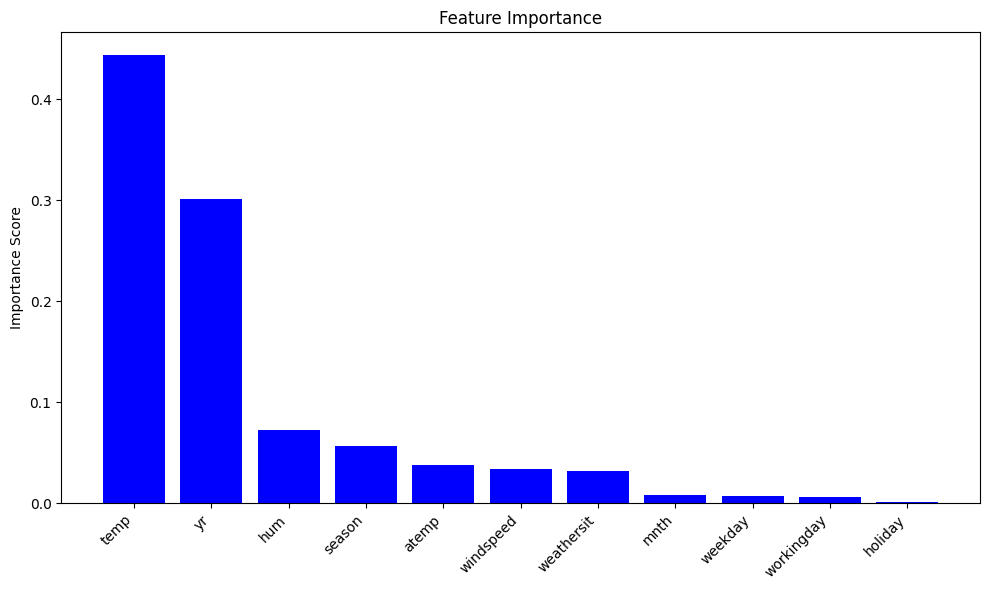

In [ ]:
gb_cost_history = None 

kf = KFold(n_splits=5, shuffle=True,random_state=42)
r2_scores, rmse_scores, mae_scores = [], [], []

fold = 1

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index].ravel(), y[test_index].ravel() #ravel makes a 2D array to an (n, ) → een 1D-array which is what is ideal for the booster

    
    model = GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Capture the cost history
    gb_cost_history = model.train_score_
    

    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Fold {fold}: R²={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}")
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    fold += 1

print("\n=== Average Model Performance Across 5 Folds ===")
print(f"Average R²   : {np.mean(r2_scores):.3f} ± {np.std(r2_scores):.3f}")
print(f"Average RMSE : {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")
print(f"Average MAE  : {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")

# VISUALIZE RESULTS
plt.figure(figsize=(12,5))
plt.plot(y_test[:100], label="Actual", color='blue')
plt.plot(y_pred[:100], label="Predicted", color='red', alpha=0.7)
plt.title("Actual vs Predicted Bike Rentals Gradient Boosting")
plt.xlabel("Sample index")
plt.ylabel("Number of rented bikes")
plt.legend()
plt.grid(True)
plt.show()

# Scatter
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test.flatten(), y=y_pred.flatten(), alpha=0.7)
plt.plot([0, np.max(y_test)], [0, np.max(y_test)], '--', color='gray')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual Bike Rentals Scatterplot")
plt.grid(True)
plt.show()

#FEATURE IMPORTANCE PLOT
feature_names = X_encoded.columns  # Pandas columns = correct
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], color='orange')
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

original_features = [
    "season", "mnth", "weekday", "weathersit",
    "temp", "atemp", "hum", "windspeed",
    "yr", "holiday", "workingday"
]

# Prepare a dictionary to accumulate grouped importances
grouped_importance = {feat: 0 for feat in original_features}

# Loop through encoded feature names and sum importances
for feat_name, importance in zip(X_encoded.columns, model.feature_importances_):
    for base_feat in original_features:
        if feat_name.startswith(base_feat):
            grouped_importance[base_feat] += importance
            break

# Convert to sorted lists
features = list(grouped_importance.keys())
importances = np.array(list(grouped_importance.values()))
sorted_idx = np.argsort(importances)[::-1]  # descending

# --- PLOT ---
plt.figure(figsize=(10, 6))
plt.bar(np.array(features)[sorted_idx], importances[sorted_idx], color="Blue")
plt.xticks(rotation=45, ha='right')
plt.title("Feature Importance")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

